# Goal

# Versions used

In [ ]:
# pdftotext version 0.68.0 from poppler-utils
# pdftocairo version 0.68.0 from poppler-utils

# Imports

In [ ]:
import os, sys
import cv2
from PIL import Image, ImageDraw
import pickle
from subprocess import check_output
import re
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Issues

# PDF Parsing

## Extract Blocks

In [ ]:

# TODO: CHECK IF PDFTOCAIRO ALSO OUTPUTS TO STDOUT 


In [ ]:
!ls

In [26]:
%%time

# Select PDF and Page to extract
path_to_pdf = '/home/tim/Code/data/IFRS/PrimeStandard/pdf/en/bayer/bayer_20184.pdf'
page = 173
convert_to = 'png'
resolution = 150
os.system(f'pdftocairo -{convert_to} -r {resolution} -f {page} -l {page} {path_to_pdf} ./tmp')


# Load Image
img_path = glob.glob('tmp*.png')[0]
print("Loading:", img_path)
img_color = cv2.imread(img_path)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Delete the tmp image from disk
os.remove(img_path)

Loading: tmp-173.png
CPU times: user 33.6 ms, sys: 7.19 ms, total: 40.8 ms
Wall time: 289 ms


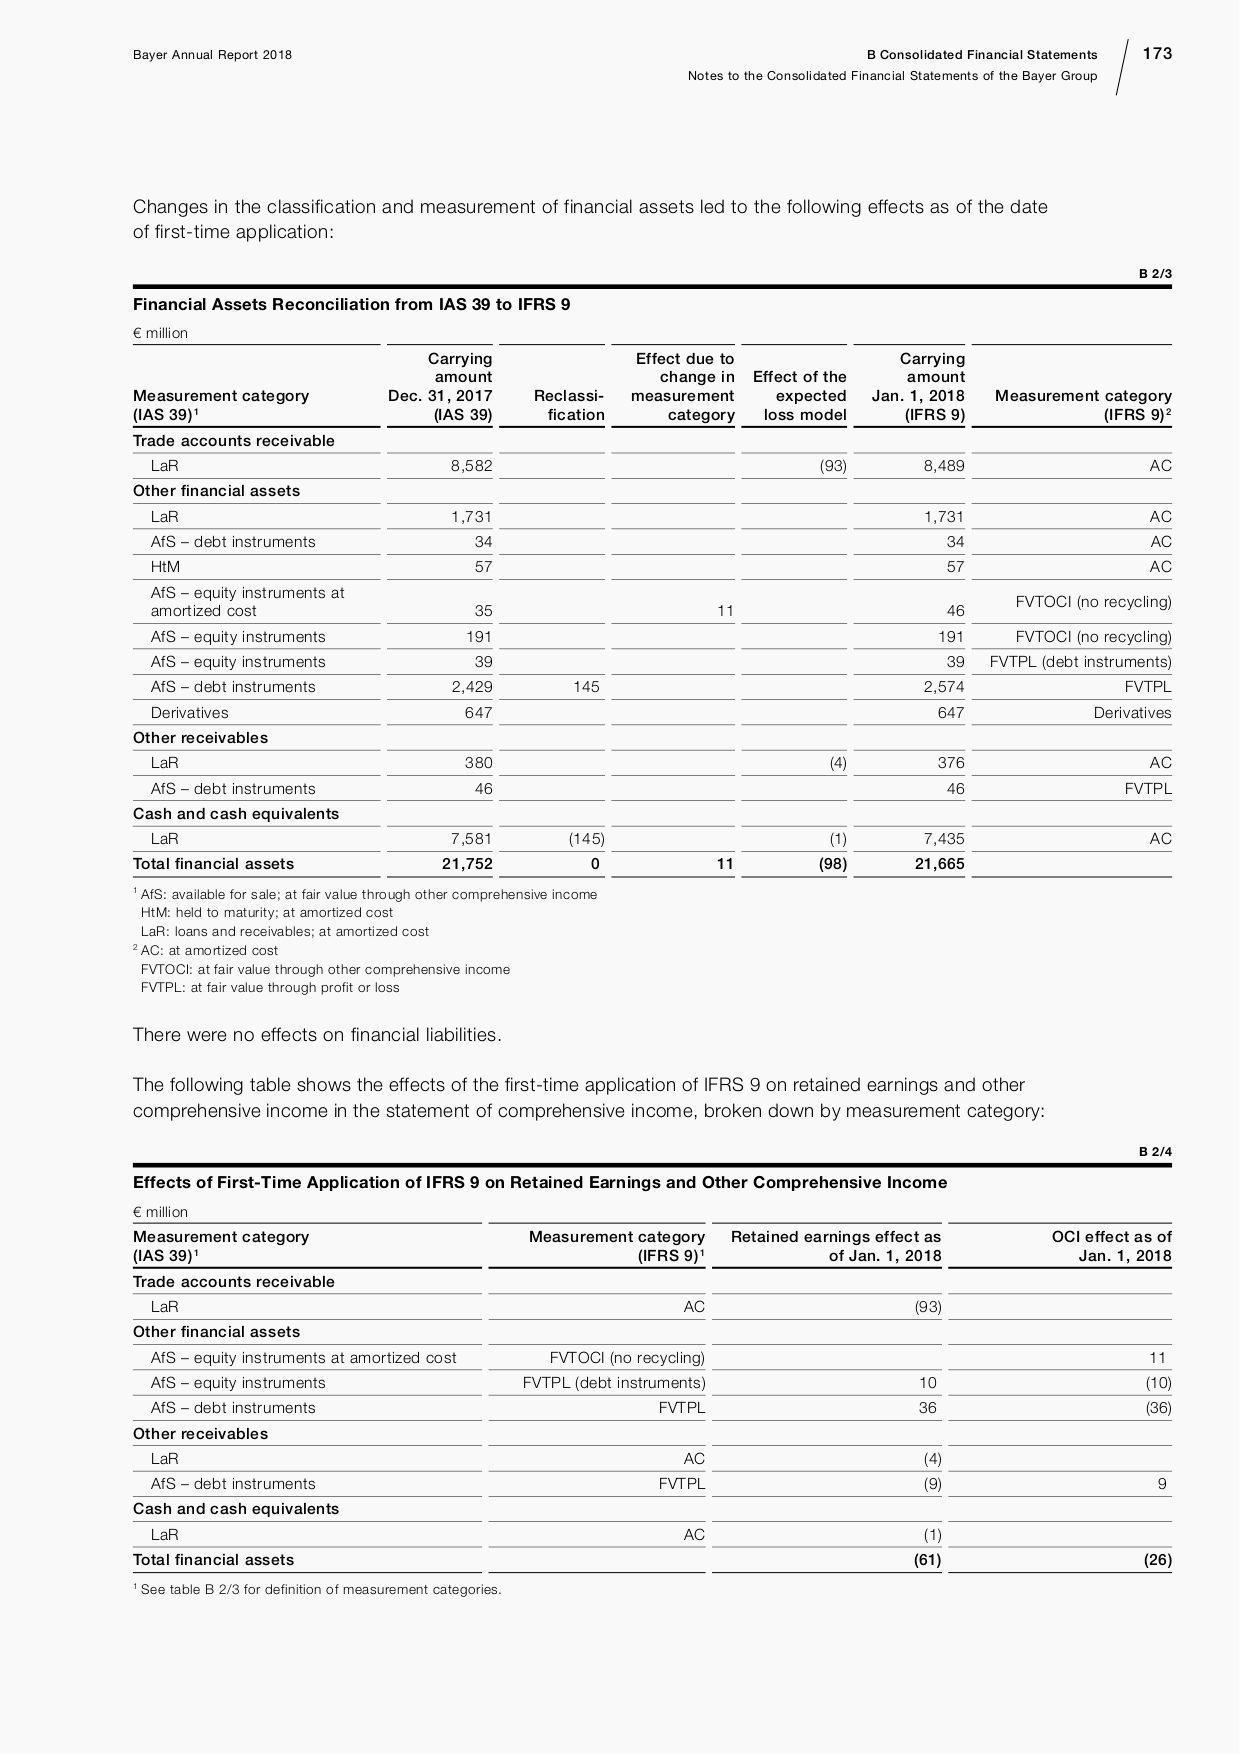

In [27]:
# Just displaying the bounding boxes
img_original = Image.fromarray(img)
img_original

In [28]:
# Some image pre-processing
edges = cv2.Canny(img, 100, 200)
kernel = np.ones((5,5), np.float32)/25
ret, mask = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY)

# Dilutes the image, which is key to finding rectangulars
dilation = cv2.dilate(mask, kernel, iterations=6) # 3 to 5 works good; the higher the less blobs you'll get

# Finds the rectangulars in the image
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Approximated rectangular areas are used to extract image area (blob)
blobs = []
for i, c in enumerate(contours):
    area = cv2.contourArea(c)

    x,y,w,h = cv2.boundingRect(c)
    
    blobs.append((x,y,w,h))
    
    # Draws the rectangles for presentation purposes, you can comment it out
    cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 1)
    
blobs = blobs[::-1] # Blobs are stored in wrong order
    
print(f"Number of Blobs detected on page {page} =>", len(blobs))

Number of Blobs detected on page 173 => 7


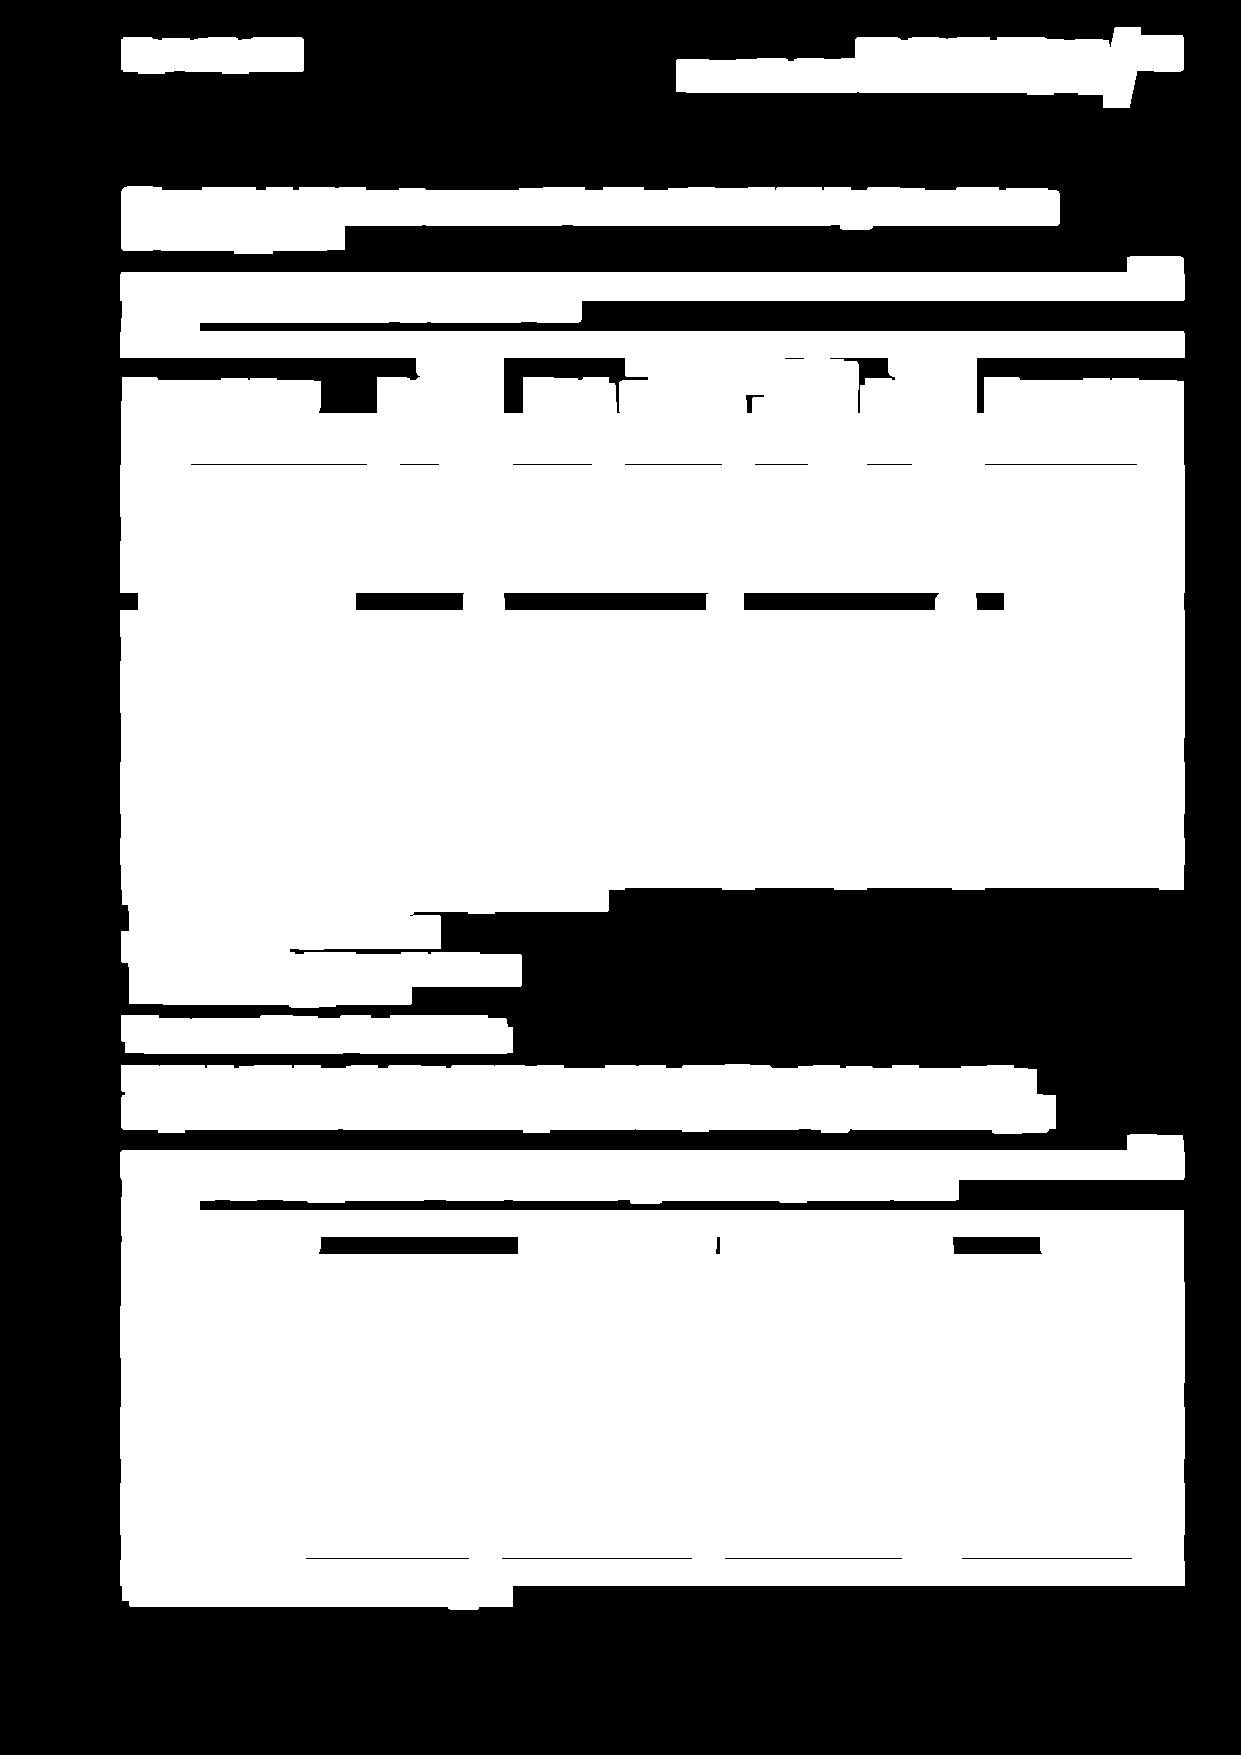

In [29]:
# Just displaying the bounding boxes
img_diluted = Image.fromarray(dilation)
img_diluted

In [448]:
# Test Output is shown from the image recognition
selected_blob = 5

blob = blobs[selected_blob]
x,y,w,h = blob
blobImg = Image.fromarray(img[y:y + h, x:x + w]) # Extracts area from image
blobImg

In [ ]:
# Displaying the bounding boxes
img_transformed = Image.fromarray(img)
img_transformed

In [ ]:
# Get y and x of the original image
y_img, x_img = img.shape

# Get the layout of the PDF with pdfinfo
out = check_output(["pdfinfo", "-rawdates", f"{path_to_pdf}"])
matches = re.search('(\d+)\.\d+\sx\s(\d+)\.\d+', str(out))
x_pdf = int(matches.group(1))
y_pdf = int(matches.group(2))

# Get the translation Ratio 
r = x_pdf/x_img
print(r)

In [ ]:
def blob_img_to_text(blob: tuple, r: float) -> str:
    """
    Takes a blob which consists of 4 coordinates (x,y,h,w)
    it also takes the translation ratio 'r' that is required
    to translate the coordinates from the image to the pdf
    
    Then pdftotext takes the coordinates to extract the text 
    from the area
    
    Returns: str: blob_text
    """
    # Extract coordinates
    x,y,w,h = blob
    
    # Translated coordinates
    x_new, y_new, w_new, h_new = int(x*r) ,int(y*r), int(w*r), int(h*r) 

    # Use Pdftotext to get blobs
    os.system(f"pdftotext -layout -l {page} -f {page} -x {x_new} -y {y_new} -W {w_new} -H {h_new} {path_to_pdf} ./tmp.txt")
    with open('./tmp.txt', "r") as f:
        blob_text: str = f.read()
            
    return blob_text

In [ ]:
# Print the Output in a nice Format
for blob in blobs:
    
    print("="*100)
    print("\n")
    blob_text = blob_img_to_text(blob, r)
    print(blob_text)

## Table Detection

In [951]:
import os, sys
import cv2
from PIL import Image, ImageDraw
import pickle
from subprocess import check_output
import re
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


In [952]:
!ls

PDF-Parser.ipynb  table.png  text_block.png  tmp.txt


In [953]:
# Load sample text-block
with open('text_block.png', 'rb') as f:
    text = pickle.load(f)

# Load sample table
with open('table.png', 'rb') as f:
    table = pickle.load(f)
    
table = text    

# Change color image to grayscale
table_gray = cv2.cvtColor(table, cv2.COLOR_BGR2GRAY)

# Gray to Binary
gray_bin = cv2.bitwise_not(table_gray)
bw = cv2.adaptiveThreshold(gray_bin, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                            cv2.THRESH_BINARY, 15, -2)

# Apply edge detection method on the image 
edges_table = cv2.Canny(bw,100,100,apertureSize = 3) 

In [954]:
bw_inv = cv2.bitwise_not(bw)

In [955]:
# Create the images that will use to extract the horizontal and vertical lines
horizontal = np.copy(bw)
vertical = np.copy(bw_inv)

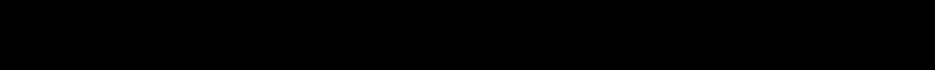

In [956]:
# Specify size on horizontal axis
cols = horizontal.shape[1]
horizontal_size = int(cols / 30)

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))

# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)

# Show extracted horizontal lines
Image.fromarray(horizontal)

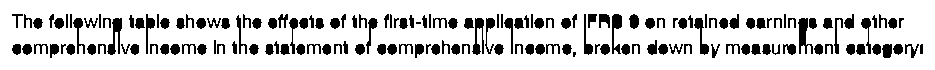

In [957]:
# Specify size on vertical axis
rows = vertical.shape[0]
verticalsize = int(rows / 5)

# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))

# Apply morphology operations
vertical = cv2.erode(vertical, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)

# Show extracted vertical lines
Image.fromarray(vertical)

Total Vertical Lines: 20
t/o Truly Vertical Lines: 0
Total Horizontal Lines: 0


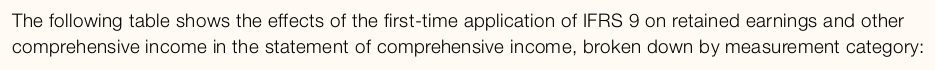

In [958]:
# TODO: The parameters for cv2.HoughLines should be based on the image size!

# Detects Lines on the pre-processed Image (Vertically)
v_lines = cv2.HoughLinesP(image=vertical, 
                        rho=100, 
                        theta=np.pi/180, 
                        threshold=100, 
                        maxLineGap=10, 
                        minLineLength=200)

# Detects Lines on the pre-processed Image (Horizontally)
h_lines = cv2.HoughLinesP(image=horizontal, 
                        rho=10, 
                        theta=np.pi/180, 
                        threshold=100, 
                        maxLineGap=10, 
                        minLineLength=100)

# Draw the vertical lines on the image
def is_truly_vertical_line(x1: int, x2: int, threshold: int = 0) -> bool:
    '''
    y1: Point 
    y2: Point
    threshold: 0 - 360 degree
    The lower the threshold, the less likely it becomes 
    that a point is discarded.
    '''
    
    if threshold > 360 or threshold < 0:
        raise ValueError("Threshold not in range of 0 - 360")
    
    # if r == 0, the line is perfectly vertical
    r = abs(x1 - x2)
    
    is_truly_vertical = False
    if r <= threshold:
        is_truly_vertical = True
    
    return is_truly_vertical
        
try:

    v_lines_truly = []
    for line in v_lines:
        for x1,y1,x2,y2 in line:
            # Not all lines are perfectly vertical
            # We calculate from the points if a line is truly vertical (based on threshold)
            if is_truly_vertical_line(x1, x2):
                v_lines_truly.append((x1,y1,x2,y2))
                # Draw line on image
                cv2.line(table,(x1,y1),(x2,y2),(0,255,0),2) # green

    print("Total Vertical Lines:", len(v_lines))
    print("t/o Truly Vertical Lines:", len(v_lines_truly))                
                
except TypeError as e:
    print("Total Vertical Lines:", 0)

            
# Draw the horizontal lines on the image
def is_truly_horizontal_line(y1: int, y2: int, threshold: int = 0) -> bool:
    '''
    y1: Point 
    y2: Point
    threshold: 0 - 360 degree
    The lower the threshold, the less likely it becomes 
    that a point is discarded.
    '''
    
    if threshold > 360 or threshold < 0:
        raise ValueError("Threshold not in range of 0 - 360")
    
    # if r == 0, the line is perfectly horizontal
    r = abs(y1 - y2)
    
    is_truly_horizontal = False
    if r <= threshold:
        is_truly_horizontal = True
    
    return is_truly_horizontal

try:
    h_lines_truly = []
    for line in h_lines:
        for x1,y1,x2,y2 in line:
            # Not all lines are perfectly horizontal
            # We calculate from the points if a line is truly horizontal (based on threshold)
            if is_truly_horizontal_line(y1, y2):
                h_lines_truly.append((x1,y1,x2,y2))
                # Draw line on image
                cv2.line(table,(x1,y1),(x2,y2),(0,0,255),2) # blue

    print("Total Horizontal Lines:", len(h_lines))
    print("t/o Truly Horizontal Lines:", len(h_lines_truly))
                
except TypeError as e:
    print("Total Horizontal Lines:", 0)
            
# Show the image in the notebook
Image.fromarray(table)

## Compare to Hendriks PDF parser

In [ ]:
# Compare to Hendriks Parser
from huge.files.pdf import pdf_to_document

In [ ]:
%%time
parsed_pdf_h = pdf_to_document(open(path_to_pdf, 'rb'))